# Predicting and Simulating NBA Games using Linear Regression

In [327]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

Loading and cleaning the data from the csv file created in the last notebook.

In [328]:
scores = pd.read_csv('game_scores.csv')
scores.head(3)

,Unnamed: 0,game_id,date,home team,home pts,away team,away pts,winner,away team 41 game win%,away team 8 game win%,home team 41 game win%,home team 8 game win%
0,0,0,2016-10-25,CLE,117.0,NYK,88.0,CLE,NaN,NaN,NaN,NaN
1,1,1,2016-10-25,GSW,100.0,SAS,129.0,SAS,NaN,NaN,NaN,NaN
2,2,2,2016-10-25,POR,113.0,UTA,104.0,POR,NaN,NaN,NaN,NaN


In [190]:
scores = scores[['date','home team', 'home pts', 'away team', 'away pts',
                 'winner', 'home team 41 game win%', 'home team 8 game win%', 
                 'away team 41 game win%', 'away team 8 game win%',]]

scores.head(3)

,date,home team,home pts,away team,away pts,winner,home team 41 game win%,home team 8 game win%,away team 41 game win%,away team 8 game win%
0,2016-10-25,CLE,117.0,NYK,88.0,CLE,NaN,NaN,NaN,NaN
1,2016-10-25,GSW,100.0,SAS,129.0,SAS,NaN,NaN,NaN,NaN
2,2016-10-25,POR,113.0,UTA,104.0,POR,NaN,NaN,NaN,NaN


# 1. Preparing our Model

### 1.1 Defining goals, choosing a model

Before we can start buildind, we must decide what kind of model we want to use. Therefore, our first question should be what do we want to predict? Ultimately, we want to use our model to simulate the remainder of the regular season. Therefore we want to be able to predict game outcomes with specified probabilities (i.e. Team 1 beats Team 2 wins with probability $p$). 

One way of doing this is to have our model predict spreads (i.e. Team 1 beats Team 2 by $x$ points). We can then map these spreads into probabilities in a natural way, because with a larger spread it is much more likely that the favorite wins than if the spread is small. 

In order to predict the spread we'll add a point_diff column to the table that his home team pts - away team pts.

In [191]:
scores['point_diff'] = scores['home pts']- scores['away pts']
scores.head()

,date,home team,home pts,away team,away pts,winner,home team 41 game win%,home team 8 game win%,away team 41 game win%,away team 8 game win%,point_diff
0,2016-10-25,CLE,117.0,NYK,88.0,CLE,NaN,NaN,NaN,NaN,29.0
1,2016-10-25,GSW,100.0,SAS,129.0,SAS,NaN,NaN,NaN,NaN,-29.0
2,2016-10-25,POR,113.0,UTA,104.0,POR,NaN,NaN,NaN,NaN,9.0
3,2016-10-26,BOS,122.0,BKN,117.0,BOS,NaN,NaN,NaN,NaN,5.0
4,2016-10-26,IND,130.0,DAL,121.0,IND,NaN,NaN,NaN,NaN,9.0


In [192]:
scores.shape

(2257, 11)

### 1.2 Partitioning Data

Before partitioning the data, we must restrict scores to a table that only contains valid records (no NaN values and before March 12th, 2018).

In [193]:
valid_scores = scores[scores['date']<'2018-03-12']
valid_scores.shape

(2229, 11)

In [194]:
valid_scores = valid_scores[valid_scores['home team 41 game win%'].notnull() & 
                valid_scores['away team 41 game win%'].notnull()]
print(valid_scores.shape)
valid_scores.head()

(1619, 11)


,date,home team,home pts,away team,away pts,winner,home team 41 game win%,home team 8 game win%,away team 41 game win%,away team 8 game win%,point_diff
591,2017-01-13,HOU,105.0,MEM,110.0,MEM,0.756098,0.750,0.585366,0.625,-5.0
595,2017-01-13,POR,109.0,ORL,115.0,ORL,0.414634,0.500,0.414634,0.250,-6.0
598,2017-01-13,UTA,110.0,DET,77.0,UTA,0.609756,0.625,0.439024,0.375,33.0
599,2017-01-14,CHI,107.0,NOP,99.0,CHI,0.487805,0.500,0.390244,0.500,8.0
600,2017-01-14,LAC,113.0,LAL,97.0,LAC,0.658537,0.750,0.341463,0.375,16.0


We now remove unneccessary columns and convert scores to an array so it is compatible with sklearn.

In [195]:
xs_df = valid_scores[['home team 41 game win%','away team 41 game win%', 'home team 8 game win%',
                      'away team 8 game win%']]

xs_df.head()

,home team 41 game win%,away team 41 game win%,home team 8 game win%,away team 8 game win%
591,0.756098,0.585366,0.750,0.625
595,0.414634,0.414634,0.500,0.250
598,0.609756,0.439024,0.625,0.375
599,0.487805,0.390244,0.500,0.500
600,0.658537,0.341463,0.750,0.375


In [196]:
ys_df = valid_scores[['point_diff']]
ys_df.head()

,point_diff
591,-5.0
595,-6.0
598,33.0
599,8.0
600,16.0


In [197]:
xs = xs_df.as_matrix()
ys = ys_df.as_matrix()

Finally, we randomly partition our data into training and testing sets using sklearn.

In [198]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xs, ys)
y_train = y_train.ravel()
y_test = y_test.ravel()
print(len(x_train),len(x_test))

1214 405


### 1.3 Feature Scaling

Because many machine learning models are sensitive to feature scaling, we rescale our data to values between !!!!!!!!! and !!!!!!!!!!. Note we only fit the scalar to our training set, and then apply the same transformation to our training and testing sets.

In [199]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler() 
scaler.fit(x_train)  
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [200]:
x_train[:3]

array([[ 0.59683418, -1.10581533, -0.60987433, -1.08604674],
       [ 1.2708404 ,  1.07513662,  1.69483364,  0.62698151],
       [ 1.10233884,  0.23630895, -0.60987433, -0.51503733]])

## 2. Training the Model

We are finally ready to train our model!

In [201]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## 3. Testing the Model

In [202]:
y_test[:5]

array([-22.,  17., -10.,  21.,   5.])

In [203]:
lin_pred = lin.predict(x_test)
lin_pred[:5]

array([ -0.06553653,   9.59374577,  -8.94087243,  15.29571352,   8.46912574])

In [204]:
sklearn.metrics.mean_absolute_error(y_true= y_test,y_pred=lin_pred)

8.4978008057462535

It looks like the model is doing okay, on average it gets the spread wrong by around 8.5 points. This seems like a lot, but lets see how it did at just predicting the winner (the sign of the spread).

In [205]:
correct_win = [np.sign(y_test[i])==np.sign(lin_pred[i]) for i in range(len(y_test))]
np.mean(correct_win)

0.74567901234567902

74% percent accuracy! For reference let's see how we would do if we just picked the team with the better 41 game win percentage (i.e. picking the team with the better record).

In [206]:
fav_pred = []
for test in x_test:
    if test[0] > test[1]:
        fav_pred.append(1)
    else:
        fav_pred.append(-1)

In [207]:
correct_win = [np.sign(y_test[i])==np.sign(fav_pred[i]) for i in range(len(y_test))]
np.mean(correct_win)

0.65679012345679011

Our model seems to do about 9% better than just guessing the favorite, which isn't bad considering all the factors we are not capturing such as injuries, roster change, rest days, etc. Before beginning simulation, I want to further examine where our model goes wrong.

## 4. Examing Accuracy

First lets plot the distribution of the model's predictions for games it missed.

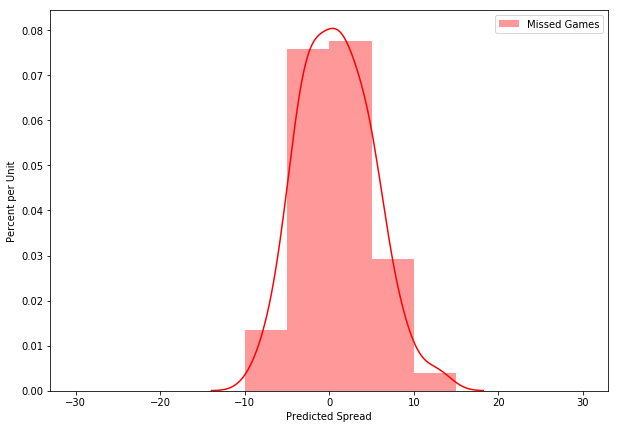

In [208]:
missed_bools = [np.sign(y_test[i])!=np.sign(lin_pred[i]) for i in range(len(y_test))]
missed_gms = lin_pred[missed_bools]

correct_bools = [np.sign(y_test[i])==np.sign(lin_pred[i]) for i in range(len(y_test))]
correct_gms = lin_pred[correct_bools]

fig, ax = plt.subplots(figsize=(10,7))

bins= np.linspace(-30,30,num=13)

sns.distplot(missed_gms,kde=True,ax=ax,bins=bins,color="red",label="Missed Games")
plt.xlabel('Predicted Spread')
plt.ylabel('Percent per Unit')
ax.legend()

As expected, the bulk of the missed games were those the modeled predicted to be close, within $\pm$ 5 points. Therefore, let's see how accurate our model was conditioned on the absolute value of its predictions.

In [287]:
def conditioned_accuracy(left,right,inner=True):
    # guess_abs = positive integer, the spread we want to condition on
    if inner == True:
        correct = np.count_nonzero([(abs(pred) <= right and abs(pred)> left) for pred in correct_gms])
        missed = np.count_nonzero([(abs(pred) <= right and abs(pred) > left) for pred in missed_gms])
        #print('num games: ',correct+missed)
        return correct/(correct + missed)
    else:
        correct = np.count_nonzero([abs(pred) >= right for pred in correct_gms])
        missed = np.count_nonzero([abs(pred) >= right for pred in missed_gms])
        #print('num games: ',correct+missed)
        return correct/(correct + missed)

In [210]:
print('accuracy when abs(pred) <= 5')
conditioned_accuracy(0,5)

accuracy when abs(pred) <= 5
num games:  192


0.5885416666666666

In [211]:
print('accuracy when 5 < abs(pred) <= 10')
conditioned_accuracy(5,10)

accuracy when 5 < abs(pred) <= 10
num games:  128


0.828125

In [212]:
print('accuracy when abs(pred) > 10')
conditioned_accuracy(0,10,inner=False)

accuracy when abs(pred) > 10
num games:  85


0.9764705882352941

Excellent, with this we will be able to condition the probability that our predicted team wins based on the predicted spread. This will help us get more accurate simulations since upsets should be more likey in games we predict to be close than in games we predict to be blowouts.

## 5. Building the Simulator

In preparing the simulator, I realized that storing the team's features in a pandas dataframe as before would not be the best approach because of the diffuculty of updating the dataframe as new games are simulated. Instead, all we need to keep track of is each team's last 41 games, specifically their points scored and their opponents points scored, and that all the other features could be easily extracted from this. Therfore I will create a class called "team" which stores these features as attributes and makes them easy to update as new games are simulated.

If I had more time I would redo that last notebook so that it worked in a similar way, but so it goes.

In [259]:
def prob_from_pred(pred):
    if abs(pred) <= 5:
        prob = conditioned_accuracy(0,5)
        return [prob, 1-prob]
    elif 5 < abs(pred) <= 10:
        prob = conditioned_accuracy(5,10)
        return [prob, 1-prob]
    else:
        prob = conditioned_accuracy(0,10,inner=False)
        return [prob, 1-prob]

In [282]:
class Team(object):
    def __init__(self,name):
        self.name = name
        self.games = []
        self.win41 = np.mean(np.count_nonzero([game.winner == self.name for game in self.games]))
        self.win8 = np.mean(np.count_nonzero([game.winner == self.name for game in self.games[-8:]]))
        self.wins = 0

    def add_game(self,game):
        self.games = self.games+[game]
        if len(self.games) > 41:
            self.games = self.games[-41:]
        if game.winner == self.name:
            self.wins += 1

class Game(object):
    def __init__(self, date, home_tm, away_tm, winner=None):
        self.date = date
        self.home_tm = home_tm
        self.away_tm = away_tm
        self.winner = winner
    def play_game():
        x = np.array([teams_dict[game.home_tm].win41, teams_dict[game.away_tm].win41,
             teams_dict[game.home_tm].win8, teams_dict[game.away_tm].win8]).reshape(1, -1)
        pred = lin.predict(x)
        probs = prob_from_pred(pred)
        win = np.random.choice(a=[1,-1],size=1,p=probs)
        if win > 0:
            game.winner = game.home_tm
        else:
            game.winner = game.away_tm

### 5.1 Downloading Schedule for Remainder of the Season

In [215]:
def clean_bbref_scores(df):
    df = df[['Date', 'Visitor/Neutral','PTS','Home/Neutral','PTS.1']]
    df.columns = ['date', 'away team', 'away pts', 'home team','home pts']
    
    return df

In [216]:
import requests
months = ['march','april']
dfs_2018 = []

for month in months:
    address = "https://www.basketball-reference.com/leagues/NBA_2018_games-"+month+".html"
    resp = requests.get(address)
    df = pd.read_html(resp.content, encoding='utf-8')[0]
    df = clean_bbref_scores(df)
    dfs_2018.append(df)

new_gms = pd.concat(dfs_2018).reset_index(drop=True)
new_gms['date'] = pd.to_datetime(new_gms['date'])
new_gms = new_gms[new_gms['date']>='2018-3-12']
new_gms.head()

,date,away team,away pts,home team,home pts
79,2018-03-12,San Antonio Spurs,93.0,Houston Rockets,109.0
80,2018-03-12,Milwaukee Bucks,121.0,Memphis Grizzlies,103.0
81,2018-03-12,Sacramento Kings,101.0,Oklahoma City Thunder,106.0
82,2018-03-12,Miami Heat,99.0,Portland Trail Blazers,115.0
83,2018-03-13,Oklahoma City Thunder,119.0,Atlanta Hawks,107.0


In [217]:
teams_dict = {'Atlanta Hawks':'ATL', 'Boston Celtics':'BOS', 'Brooklyn Nets':'BKN',
             'Charlotte Hornets':'CHA', 'Chicago Bulls':'CHI', 'Cleveland Cavaliers':'CLE',
             'Dallas Mavericks':'DAL', 'Denver Nuggets':'DEN', 'Detroit Pistons':'DET',
             'Golden State Warriors':'GSW', 'Houston Rockets':'HOU', 'Indiana Pacers':'IND',
             'Los Angeles Clippers':'LAC','Los Angeles Lakers':'LAL','Memphis Grizzlies':'MEM',
             'Miami Heat':'MIA','Milwaukee Bucks':'MIL', 'Minnesota Timberwolves':'MIN',
             'New Orleans Pelicans':'NOP', 'New York Knicks':'NYK', 'Oklahoma City Thunder':'OKC',
             'Orlando Magic':'ORL','Philadelphia 76ers':'PHI','Phoenix Suns':'PHX',
             'Portland Trail Blazers':'POR','Sacramento Kings':'SAC','San Antonio Spurs':'SAS',
             'Toronto Raptors':'TOR','Utah Jazz':'UTA','Washington Wizards':'WAS'}

In [218]:
away_tms = new_gms['away team'].tolist()
home_tms = new_gms['home team'].tolist()

away_short = [teams_dict[away_tm] for away_tm in away_tms]
home_short = [teams_dict[home_tm] for home_tm in home_tms]

new_gms['away team'] = away_short
new_gms['home team'] = home_short

new_gms.head()

,date,away team,away pts,home team,home pts
79,2018-03-12,SAS,93.0,HOU,109.0
80,2018-03-12,MIL,121.0,MEM,103.0
81,2018-03-12,SAC,101.0,OKC,106.0
82,2018-03-12,MIA,99.0,POR,115.0
83,2018-03-13,OKC,119.0,ATL,107.0


### 5.2 Simulating Remainder of the Season

We first initialize the teams by creating a team object for each team and adding a game object to each team for each game they played in the 2017-18 season, before March 12th, 2018. We print out each team's wins as of the morning of March 12th to make sure everything worked correctly.

In [317]:
teams = np.unique(valid_scores['home team'])
teams_dict = dict.fromkeys(teams)  
for team in teams:
    teams_dict[team] = Team(name=team)

scores_2018 = valid_scores[valid_scores['date']>= '2017-10-17']
    
games_obj =[]
for index, row in scores_2018.iterrows():
    g = Game(date=row['date'],home_tm=row['home team'],
             away_tm=row['away team'],winner=row['winner'])
    games_obj.append(g)
for game in games_obj:
    home_tm = teams_dict[game.home_tm]
    away_tm = teams_dict[game.away_tm]
    home_tm.add_game(game)
    away_tm.add_game(game)
for team in teams:
        print(teams_dict[team].name,teams_dict[team].wins)

ATL 20
BKN 21
BOS 46
CHA 29
CHI 23
CLE 38
DAL 21
DEN 37
DET 30
GSW 51
HOU 52
IND 39
LAC 36
LAL 30
MEM 18
MIA 36
MIL 35
MIN 39
NOP 38
NYK 24
OKC 39
ORL 20
PHI 36
PHX 19
POR 40
SAC 21
SAS 37
TOR 49
UTA 37
WAS 38


We can now pass these teams along with the remaining schedule of games into the sim_season funciton which simulates the rest of the season. 

In [318]:
def get_wins(team):
    return teams_dict[team].wins

In [319]:
def sim_season(teams_dict,new_gms):
    # Simulating new games
    for index, row in new_gms.iterrows():
        game = Game(date=row['date'],home_tm=row['home team'],away_tm=row['away team'])
        play_game(teams_dict,game)
        teams_dict[game.home_tm].add_game(game)
        teams_dict[game.away_tm].add_game(game)
    # Determining Western Conference Playoff Teams
    west_tms = [team for team in ['DAL','DEN','GSW','HOU','LAC','LAL','MEM',
                                              'MIN','NOP','OKC','PHX','POR','SAC','SAS','UTA']]
    west_tms = sorted(west_tms,key=get_wins,reverse=True)
    playoff_tms = west_tms[:8]
    return playoff_tms

In [321]:
sim_season(teams_dict,new_gms)

['GSW', 'HOU', 'LAC', 'NOP', 'POR', 'SAS', 'OKC', 'DEN']

Finally we simulate the rest of the season 2000 times and see in what proportion of them the Jazz make the playoffs. This will be our estimate of Utah's chances of making it.

In [324]:
def sim_n_seasons(teams_dict,new_gms,n):
    utah_in = []
    for i in range(n):
        playoff_tms = sim_season(teams_dict,new_gms)
        if 'UTA' in playoff_tms:
            utah_in.append(1)
        else:
            utah_in.append(0)
    return np.mean(utah_in)

In [326]:
sim_n_seasons(teams_dict,new_gms,n=2000)

1.0

Alright, according to our model, the Utah Jazz have effictively a 100% chance of making the NBA playoffs as of March 12th, 2018! That seems rather high, considering that fivethirtyeight gave the Jazz a 92% chance as of March 12th, but that makes sense when you consider all the factors our model is not capturing that may derail the Jazz's season such as fatigue, injuries, etc.